<a href="https://colab.research.google.com/github/pulindu-seniya-silva/Fake-News-Detection-NLP/blob/main/Fake_News_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#installing NLTK for text preprocessing
!pip install nltk


In [ ]:
 #install Hugging Face 'transformers' library for BERT/deep Learning
!pip install transformers

# Loading the dataset

In [ ]:

#Data Manipulation and Exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
# Mount Google Drive (if the file is there)
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/fake_news_dataset.csv'

df = pd.read_csv(file_path)
print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                                  title  \
0               Foreign Democrat final.   
1   To offer down resource great point.   
2          Himself church myself carry.   
3                  You unit its should.   
4  Billion believe employee summer how.   

                                                text        date    source  \
0  more tax development both store agreement lawy...  2023-03-10  NY Times   
1  probably guess western behind likely next inve...  2022-05-25  Fox News   
2  them identify forward present success risk sev...  2022-09-01       CNN   
3  phone which item yard Republican safe where po...  2023-02-07   Reuters   
4  wonder myself fact difficult course forget exa...  2023-04-03       CNN   

                 author    category label  
0          Paula George    Politics  real  
1           Joseph Hill    Politics  fake  
2        Ju

In [ ]:
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     20000 non-null  object
 1   text      20000 non-null  object
 2   date      20000 non-null  object
 3   source    19000 non-null  object
 4   author    19000 non-null  object
 5   category  20000 non-null  object
 6   label     20000 non-null  object
dtypes: object(7)
memory usage: 1.1+ MB


In [ ]:
#import libraries
#Natural Language Processing (Text Cleaning and Preprocessing)
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

#Machine Learning (Feature Extraction and Models)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#Downloard NLTK resources
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Preliminary Data Inspection

In [ ]:
#Check the total number of rows and columns
print(f"\nTotal rows and columns: {df.shape}")


Total rows and columns: (20000, 7)


In [ ]:
#Check for missing values in each column
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
title          0
text           0
date           0
source      1000
author      1000
category       0
label          0
dtype: int64


# imputation (Handling Missing Vlaues)

In [ ]:
#Fill Nan values in 'author' and 'source' columns with 'Unknow'
df['author'] = df['author'].fillna('Unknow')
df['source'] = df['source'].fillna('Unknow')

#Re-check for nulls to confirm
print("\nMissing values after imputation:")
print(df.isnull().sum)


Missing values after imputation:
<bound method DataFrame.sum of        title   text   date  source  author  category  label
0      False  False  False   False   False     False  False
1      False  False  False   False   False     False  False
2      False  False  False   False   False     False  False
3      False  False  False   False   False     False  False
4      False  False  False   False   False     False  False
...      ...    ...    ...     ...     ...       ...    ...
19995  False  False  False   False   False     False  False
19996  False  False  False   False   False     False  False
19997  False  False  False   False   False     False  False
19998  False  False  False   False   False     False  False
19999  False  False  False   False   False     False  False

[20000 rows x 7 columns]>


# Feature Selection

In [ ]:
#Combine 'title' and 'text' into a single 'full_text' feature
#using a space (' ') as separator
df['full_text'] = df['title'] + ' ' + df['text']

# Only map if the labels are still strings
if df['label'].dtype == 'object':
    df['label'] = df['label'].astype(str).str.strip().str.lower().map({'fake': 1, 'real': 0})

# Drop any rows that failed to map to avoid crashing the model
df = df.dropna(subset=['label'])
df['label'] = df['label'].astype(int)
print(df['label'].value_counts())

#Display the result
print("\nDataFrame after combining text and mapping label:")
print(df[['full_text', 'label']].head())

label
1    10056
0     9944
Name: count, dtype: int64

DataFrame after combining text and mapping label:
                                           full_text  label
0  Foreign Democrat final. more tax development b...      0
1  To offer down resource great point. probably g...      1
2  Himself church myself carry. them identify for...      1
3  You unit its should. phone which item yard Rep...      1
4  Billion believe employee summer how. wonder my...      1


# Exploratory Data Analysis(EDA)- Class Imbalance

In [ ]:
#Check the distribution of the target variable ('label')
print("\nDistribution of News Labels (0=Real, 1=Fake):")
print((df['label']).value_counts())


Distribution of News Labels (0=Real, 1=Fake):
label
1    10056
0     9944
Name: count, dtype: int64


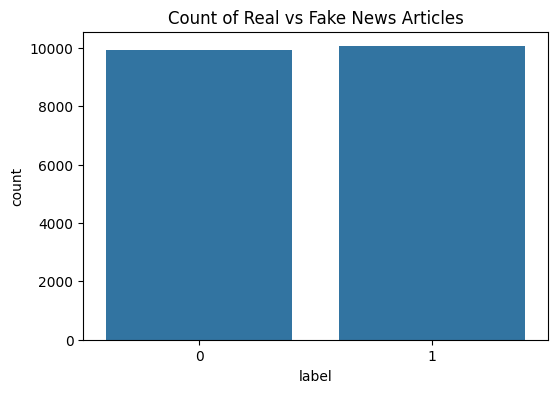

In [ ]:
#visualize the distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title('Count of Real vs Fake News Articles')
plt.show()

# Text Preprocessing and Tokenization

In [ ]:
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Define the Cleaning function
# we rely on the TfidVectorizer's built-in 'stop_words' functionality later,
# so we only perform essential cleaning here.

def clean_text(text):
  #convert text to lowercase
  text = text.lower()

  # Remove special characters, numbers, and punctuation (keep only letters and spaces)
  # Replace anything that is NOT a letter or a space with a single space
  text = re.sub(r'[^a-zA-Z\s]', ' ', text)

  # Replace multiple spaces with a single space and trim surrounding whitespace
  text = re.sub(r'\s+', ' ', text).strip()

  # Filter out single-character word (like 'a' or 'i' if they somehow survived stop word removal)
  words = [word for word in text.split() if len(word) > 1]

  return ' '.join(words)

# Apply the cleaning function to the 'full_text' column
df['cleaned_text'] = df['full_text'].apply(clean_text)

print("--- Text Cleaning Applied ---")
print(f"Original Text Sample: {df['full_text'].iloc[0][:100]}...")
print(f"Cleaned Text Sample: {df['cleaned_text'].iloc[0][:100]}...")




--- Text Cleaning Applied ---
Original Text Sample: Foreign Democrat final. more tax development both store agreement lawyer hear outside continue reach...
Cleaned Text Sample: foreign democrat final more tax development both store agreement lawyer hear outside continue reach ...


# Data Splitting (Train-Test Split)

In [ ]:
X = df['cleaned_text']
y = df['label']

# Before splitting, create a temporary DataFrame to handle NaN values in 'y'
# This ensures that rows with missing labels are dropped consistently from both X and y.
combined_data = pd.DataFrame({'cleaned_text': X, 'label': y})
combined_data.dropna(subset=['label'], inplace=True)

X = combined_data['cleaned_text']
y = combined_data['label']

# Split the data, ensuring the label distribution is maintained (stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("--- Data Splitting Complete ---")
print(f"Total sample: {len(X)}")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}\n")

--- Data Splitting Complete ---
Total sample: 20000
Training samples: 16000
Testing samples: 4000



# Advanced cleaning

In [ ]:
import re
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def advanced_clean(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text) # Remove numbers and punctuation
    words = text.split()
    # Remove stop words (the, is, at) and very short words
    words = [w for w in words if w not in stop_words and len(w) > 2]
    return " ".join(words)

df['cleaned_text'] = df['full_text'].apply(advanced_clean)

# Feature Engineering (TF-IDF Vectorization)

In [ ]:
# 1. Intialize the TF-IDF Vectorizer
# Change your TfidfVectorizer to include pairs of words
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7, ngram_range=(1, 2), min_df=5)

In [ ]:
# 2. Fit and Transform (CRITICAL step: Fit only on Training Data!)
# .fit() learns the vocabulary from X_train
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

In [ ]:
# 3. Transform (Apply the vocabulary learned from X_train to the test data)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
print("--- TF-IDF Vectorization Complete ---")
print(f"X_train_tfidf shape: {X_train_tfidf.shape}")
print(f"X_test_tfidf shape: {X_test_tfidf.shape}")
print(f"Vocabulary size (number of features): {len(tfidf_vectorizer.get_feature_names_out())}")

--- TF-IDF Vectorization Complete ---
X_train_tfidf shape: (16000, 374515)
X_test_tfidf shape: (4000, 374515)
Vocabulary size (number of features): 374515


# Model Development and Training

In [ ]:
from sklearn.linear_model import LogisticRegression

# 1. Improved Vectorizer (looks for 1-word and 2-word patterns) specifically for Logistic Regression
tfidf_lr = TfidfVectorizer(max_df=0.7, min_df=5, ngram_range=(1, 2))
X_train_tfidf_lr = tfidf_lr.fit_transform(X_train)
X_test_tfidf_lr = tfidf_lr.transform(X_test)

# 2. Use Logistic Regression (often more stable than PAC)
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf_lr, y_train)

# 3. Predict and check
y_pred_lr = model.predict(X_test_tfidf_lr)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_lr)*100:.2f}%")

Logistic Regression Accuracy: 50.58%


# Save the model

In [ ]:
import pickle

# 1. Save the trained Passive Aggressive Model
# 'wb' stands for "Write Binary"
with open('fake_news_model.pkl', 'wb') as model_file:
    pickle.dump(pac, model_file)

# 2. Save the TF-IDF Vectorizer
# This is crucial! Without this, you cannot transform new text for prediction.
with open('tfidf_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(tfidf_vectorizer, vectorizer_file)

print("Success! Both the model and vectorizer have been saved as .pkl files.")

Success! Both the model and vectorizer have been saved as .pkl files.


In [ ]:
# Check if labels are actually 0 and 1
print(df['label'].value_counts())

label
1    10056
0     9944
Name: count, dtype: int64


In [ ]:
pac = PassiveAggressiveClassifier(
    C=0.5,             # Regularization strength
    max_iter=100,      # Give it more time to learn
    validation_fraction=0.1,
    n_iter_no_change=5, # Stop when it stops improving
    random_state=42
)
pac.fit(X_train_tfidf, y_train)

PassiveAggressiveClassifier(C=0.5, max_iter=100, random_state=42)

In [ ]:
!pip install transformers[torch] datasets
from transformers import BertTokenizer, BertForSequenceClassification

# Load the brain of the model
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Check for empty strings after cleaning
empty_rows = df[df['cleaned_text'] == ''].shape[0]
print(f"Empty text rows: {empty_rows}")

# Check class balance in Training set
print("Training label distribution:")
print(y_train.value_counts(normalize=True))

Empty text rows: 0
Training label distribution:
label
1    0.502812
0    0.497188
Name: proportion, dtype: float64


# Testing and Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Ensure X_test_tfidf has the correct number of features by re-transforming with the original vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# 1. Predict (The "Exam" Step)
# We ask the model to guess the labels for the unseen test data
y_pred = pac.predict(X_test_tfidf)

# 2. Calculate Accuracy
score = accuracy_score(y_test, y_pred)
print(f'Accuracy: {round(score*100, 2)}%')

# 3. Create the Confusion Matrix
# This shows: [ [True Positives, False Negatives], [False Positives, True Negatives] ]
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 4. Detailed Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 50.35%

Confusion Matrix:
[[ 988 1001]
 [ 985 1026]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50      1989
           1       0.51      0.51      0.51      2011

    accuracy                           0.50      4000
   macro avg       0.50      0.50      0.50      4000
weighted avg       0.50      0.50      0.50      4000



In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer

# Load the BERT tokenizer
print("Loading BERT tokenizer...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Prepare input data for BERT
def tokenize_data(texts, tokenizer, max_len=128):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
                            text,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_len,      # Pad & truncate all sentences.
                            padding = 'max_length',
                            truncation = True,         # Explicitly truncate longer sequences
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the list
        input_ids.append(encoded_dict['input_ids'])

        # Add its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    return input_ids, attention_masks

# Tokenize training and test data
MAX_LEN = 128 # You can adjust this based on your text length distribution
print(f"Tokenizing training data with MAX_LEN={MAX_LEN}...")
X_train_input_ids, X_train_attention_masks = tokenize_data(X_train.tolist(), tokenizer, MAX_LEN)
print(f"Tokenizing test data with MAX_LEN={MAX_LEN}...")
X_test_input_ids, X_test_attention_masks = tokenize_data(X_test.tolist(), tokenizer, MAX_LEN)

# Convert labels to tensors
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create the DataLoader for our training set.
batch_size = 32 # You can adjust this

train_dataset = TensorDataset(X_train_input_ids, X_train_attention_masks, y_train_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our test set.
prediction_dataset = TensorDataset(X_test_input_ids, X_test_attention_masks, y_test_tensor)
prediction_sampler = SequentialSampler(prediction_dataset)
prediction_dataloader = DataLoader(prediction_dataset, sampler=prediction_sampler, batch_size=batch_size)

print("BERT data preparation complete: Tokenization, Tensor Conversion, and DataLoader setup.")
print(f"Number of training batches: {len(train_dataloader)}")
print(f"Number of prediction batches: {len(prediction_dataloader)}")

Loading BERT tokenizer...
Tokenizing training data with MAX_LEN=128...
Tokenizing test data with MAX_LEN=128...
BERT data preparation complete: Tokenization, Tensor Conversion, and DataLoader setup.
Number of training batches: 500
Number of prediction batches: 125


In [ ]:
import torch
from transformers import BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW # Corrected import for AdamW
from tqdm.notebook import tqdm

# Load BertForSequenceClassification, the pretrained BERT model with a single linear layer on top.
# `num_labels` parameter dictates the number of output labels to predict (2 for binary classification).
print("Loading BertForSequenceClassification model...")
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2,      # The number of output labels--2 for binary classification.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU, if available.
if torch.cuda.is_available():
    device = torch.device("cuda")
    model.cuda()
    print("Using GPU for training.")
else:
    device = torch.device("cpu")
    print("Using CPU for training.")

# Optimizer & Learning Rate Scheduler
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)
epochs = 3 # You can adjust this
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = torch.argmax(preds, dim=1).flatten()
    labels_flat = labels.flatten()
    return (pred_flat == labels_flat).sum().item() / len(labels_flat)

# --- Training Loop ---
print("\nStarting BERT model training...")

for epoch_i in range(0, epochs):
    print(f'======== Epoch {epoch_i + 1} / {epochs} ========\n')

    # ======================================== Training ========================================
    model.train() # Put the model into training mode.
    total_train_loss = 0

    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # The 'outputs' object contains the loss, logits, and any other data returned by the model.
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs.loss
        logits = outputs.logits

        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"  Average training loss: {avg_train_loss:.2f}")

print("\nBERT training complete!")

Loading BertForSequenceClassification model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using GPU for training.

Starting BERT model training...
======== Epoch 1 / 3 ========



  0%|          | 0/500 [00:00<?, ?it/s]

  Average training loss: 0.70
======== Epoch 2 / 3 ========



  0%|          | 0/500 [00:00<?, ?it/s]

  Average training loss: 0.69
======== Epoch 3 / 3 ========



  0%|          | 0/500 [00:00<?, ?it/s]

  Average training loss: 0.69

BERT training complete!


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("\nRunning BERT evaluation on test set...")

model.eval() # Put the model in evaluation mode

predictions = []
true_labels = []

# Predict
for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad(): # No need to compute gradients during evaluation
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = outputs.logits

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(logits)
    true_labels.append(label_ids)

# Concatenate the predictions and the true labels from all batches
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Get the predicted labels (index of the highest logit)
predicted_labels = np.argmax(predictions, axis=1).flatten()

# Calculate metrics
bert_accuracy = accuracy_score(true_labels, predicted_labels)
bert_confusion_matrix = confusion_matrix(true_labels, predicted_labels)
bert_classification_report = classification_report(true_labels, predicted_labels)

print("--- BERT Model Evaluation Complete ---")
print(f"BERT Accuracy: {bert_accuracy*100:.2f}%")
print("\nConfusion Matrix (BERT):")
print(bert_confusion_matrix)
print("\nClassification Report (BERT):")
print(bert_classification_report)



Running BERT evaluation on test set...
--- BERT Model Evaluation Complete ---
BERT Accuracy: 49.68%

Confusion Matrix (BERT):
[[1981    8]
 [2005    6]]

Classification Report (BERT):
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      1989
           1       0.43      0.00      0.01      2011

    accuracy                           0.50      4000
   macro avg       0.46      0.50      0.33      4000
weighted avg       0.46      0.50      0.33      4000

